##1. Загрузка пакетов - библиотек

In [69]:
# Импорт необходимых библиотек
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import random
from keras import models, layers
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Установка seed для воспроизводимости результатов
np.random.seed(17)
tf.random.set_seed(17)

##2. Загрузка датасета

In [70]:
dataset_root = Path("/content/iad-lab3/Vehicles")

# Проверка наличия датасета
if dataset_root.exists():
    print("Датасет уже найден по указанному пути.")
else:
    print("Датасет не найден. Выполняется загрузка с GitHub...")
    !git clone https://github.com/Daria-Chernykh/iad-lab3.git

# Получение списка классов (подкаталогов)
class_names = sorted(
    [item.name for item in dataset_root.iterdir() if item.is_dir()]
)

# Фиксация количества классов
num_classes = len(class_names)

print("\nНайденные классы:")
for idx, class_name in enumerate(class_names):
    print(f"{idx + 1}. {class_name}")

print(f"\nКоличество классов k = {num_classes}")

# Допустимые расширения изображений (в нижнем регистре)
image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".webp"}

# Подсчёт количества изображений в каждой папке класса
print("\nКоличество изображений по классам:")

total_images = 0

for class_name in class_names:
    class_path = dataset_root / class_name

    num_images = sum(
        1 for f in class_path.iterdir()
        if f.is_file() and f.suffix.lower() in image_extensions
    )

    total_images += num_images
    print(f"{class_name}: {num_images}")

print(f"\nОбщее количество изображений в датасете: {total_images}")

Датасет уже найден по указанному пути.

Найденные классы:
1. Auto Rickshaws
2. Bikes
3. Cars
4. Motorcycles
5. Planes
6. Ships
7. Trains

Количество классов k = 7

Количество изображений по классам:
Auto Rickshaws: 800
Bikes: 800
Cars: 790
Motorcycles: 800
Planes: 800
Ships: 800
Trains: 800

Общее количество изображений в датасете: 5590


В лабораторной работе используется датасет изображений транспортных средств (Vehicles). Набор данных включает 7 классов:
* Авторикши (Auto Rickshaws),
* Велосипеды (Bikes),
* Машины (Cars),
* Мотоциклы (Motorcycles),
* Самолеты (Planes),
* Корабли (Ships),
* Поезда (Trains).

Каждый класс представлен отдельной папкой с изображениями. Общее количество изображений в датасете составляет 5590. Число изображений в классах близко по величине (от 790 до 800 изображений на класс), что позволяет считать датасет практически сбалансированным и пригодным для решения задачи многоклассовой классификации с использованием сверточных нейронных сетей.

##3. Выбор и фиксация размерности изображений

In [71]:
# Фиксация размерности входных изображений
img_height = 128
img_width = 128
input_shape = (img_height, img_width, 3)

# Размер мини-пакета
batch_size = 128

##4. Формирование обучающей, валидационной и тестовой выборок

####4.1 Физическое разбиение датасета по папкам

In [72]:
source_root = Path("/content/iad-lab3/Vehicles")
target_root = Path("/content/Vehicles_split")

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".webp"}

# Создание структуры каталогов
for split in ["train", "val", "test"]:
    for class_dir in source_root.iterdir():
        if class_dir.is_dir():
            (target_root / split / class_dir.name).mkdir(parents=True, exist_ok=True)

# Разбиение изображений по классам
for class_dir in source_root.iterdir():
    if not class_dir.is_dir():
        continue

    images = [
        img for img in class_dir.iterdir()
        if img.is_file() and img.suffix.lower() in image_extensions
    ]

    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]

    for img in train_images:
        shutil.copy(img, target_root / "train" / class_dir.name / img.name)

    for img in val_images:
        shutil.copy(img, target_root / "val" / class_dir.name / img.name)

    for img in test_images:
        shutil.copy(img, target_root / "test" / class_dir.name / img.name)

print("Разбиение датасета на train / val / test завершено.")


Разбиение датасета на train / val / test завершено.


####4.2 Создание генераторов изображений

In [73]:
# Генератор с аугментацией — только для обучающей выборки
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Генераторы без аугментации — для валидации и теста
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    target_root / "train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    target_root / "val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    target_root / "test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5587 images belonging to 7 classes.
Found 4977 images belonging to 7 classes.
Found 4998 images belonging to 7 classes.


####4.3 Вывод количества изображений в каждой выборке

In [74]:
num_train = train_generator.samples
num_val = val_generator.samples
num_test = test_generator.samples

print("Количество изображений в выборках:")
print(f"Обучающая выборка: {num_train}")
print(f"Валидационная выборка: {num_val}")
print(f"Тестовая выборка: {num_test}")
print(f"Общее количество изображений: {num_train + num_val + num_test}")

Количество изображений в выборках:
Обучающая выборка: 5587
Валидационная выборка: 4977
Тестовая выборка: 4998
Общее количество изображений: 15562


Исходный датасет был физически разделён на обучающую, валидационную и тестовую выборки в соотношении 60% / 20% / 20% отдельно для каждого класса. Аугментация данных применялась только к обучающей выборке, что позволяет повысить обобщающую способность модели и избежать искажения оценок качества на валидационных и тестовых данных.

##5. Построение сверточной нейронной сети «с нуля» (Conv2D + MaxPooling + Dense)

In [75]:
# 1. СОЗДАНИЕ CALLBACK'ОВ
callbacks = [
    # Ранняя остановка при переобучении
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # Количество эпох без улучшения
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),

    # Уменьшение learning rate при плато
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Уменьшение LR в 2 раза
        patience=7,  # Количество эпох без улучшения
        min_lr=1e-6,  # Минимальный learning rate
        verbose=1,
        mode='min'
    )
]

# 2. СЛОЙ АУГМЕНТАЦИИ
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# 3. ПРОСТАЯ КЛАССИФИКАЦИОННАЯ МОДЕЛЬ
def create_simple_classifier():
    """
    Простая CNN для классификации без автокодировщика
    """
    inputs = layers.Input(shape=(128, 128, 3))

    # Аугментация
    x = data_augmentation(inputs)

    # Нормализация
    x = layers.Rescaling(1./255)(x)

    # Сверточные блоки
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Глобальное усреднение вместо Flatten (быстрее)
    x = layers.GlobalAveragePooling2D()(x)

    # Полносвязные слои
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Выходной слой (7 классов)
    outputs = layers.Dense(7, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)

# 4. СОЗДАНИЕ И КОМПИЛЯЦИЯ МОДЕЛИ
print("="*60)
print("СОЗДАНИЕ МОДЕЛИ")
print("="*60)

model = create_simple_classifier()

# Компиляция с двумя loss функциями
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.summary()


СОЗДАНИЕ МОДЕЛИ


In [76]:
# 5. ОБУЧЕНИЕ МОДЕЛИ
print("\n" + "="*60)
print("ОБУЧЕНИЕ МОДЕЛИ")
print("="*60)

history = model.fit(
    train_generator,
    steps_per_epoch=max(1, num_train // batch_size),
    epochs=100,
    validation_data=val_generator,
    validation_steps=max(1, num_val // batch_size),
    callbacks=callbacks,
    verbose=1
)

# classification_model.summary()

# 6. ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ
print("\n" + "="*60)
print("ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*60)

test_results = model.evaluate(
    test_generator,
    steps=max(1, num_test // batch_size),
    verbose=1
)

print(f"\nТЕСТОВЫЕ МЕТРИКИ:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.1f}%)")



ОБУЧЕНИЕ МОДЕЛИ


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
 2/43 ━━━━━━━━━━━━━━━━━━━━ 3:07 5s/step - accuracy: 0.1250 - loss: 1.9459  

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.1370 - loss: 1.9461 - val_accuracy: 0.1443 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 2/100
 1/43 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 0.1172 - loss: 1.9477

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.1172 - loss: 1.9477 - val_accuracy: 0.1435 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - accuracy: 0.1411 - loss: 1.9459 - val_accuracy: 0.1433 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.0859 - loss: 1.9480 - val_accuracy: 0.1431 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step - accuracy: 0.1288 - loss: 1.9460 - val_accuracy: 0.1443 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.1562 - loss: 1.9467 - val_accuracy: 0.1447 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.1515 - loss: 1.9459 - val_accuracy: 0.1423 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 8/100
 1/43 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.1205 - loss: 1.9460
Epoch 8: ReduceLR

Если хочешь можешь написать что-то

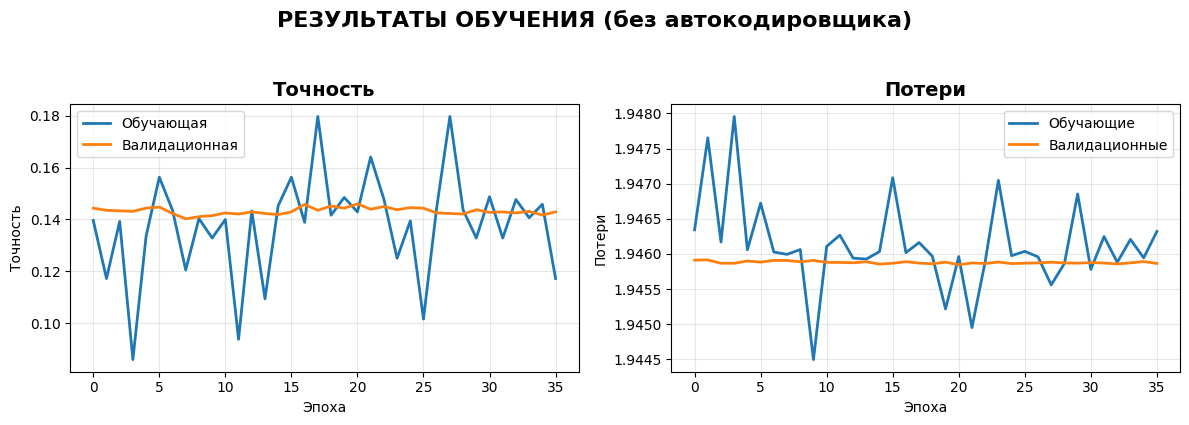

In [77]:
# 7. ВИЗУАЛИЗАЦИЯ
def plot_simple_training_results(history):
    """
    Упрощенная визуализация (только accuracy и loss)
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # График точности
    axes[0].plot(history.history['accuracy'], label='Обучающая', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Валидационная', linewidth=2)
    axes[0].set_title('Точность', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # График потерь
    axes[1].plot(history.history['loss'], label='Обучающие', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Валидационные', linewidth=2)
    axes[1].set_title('Потери', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Потери')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('РЕЗУЛЬТАТЫ ОБУЧЕНИЯ (без автокодировщика)',
                fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

plot_simple_training_results(history)

вывод


ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


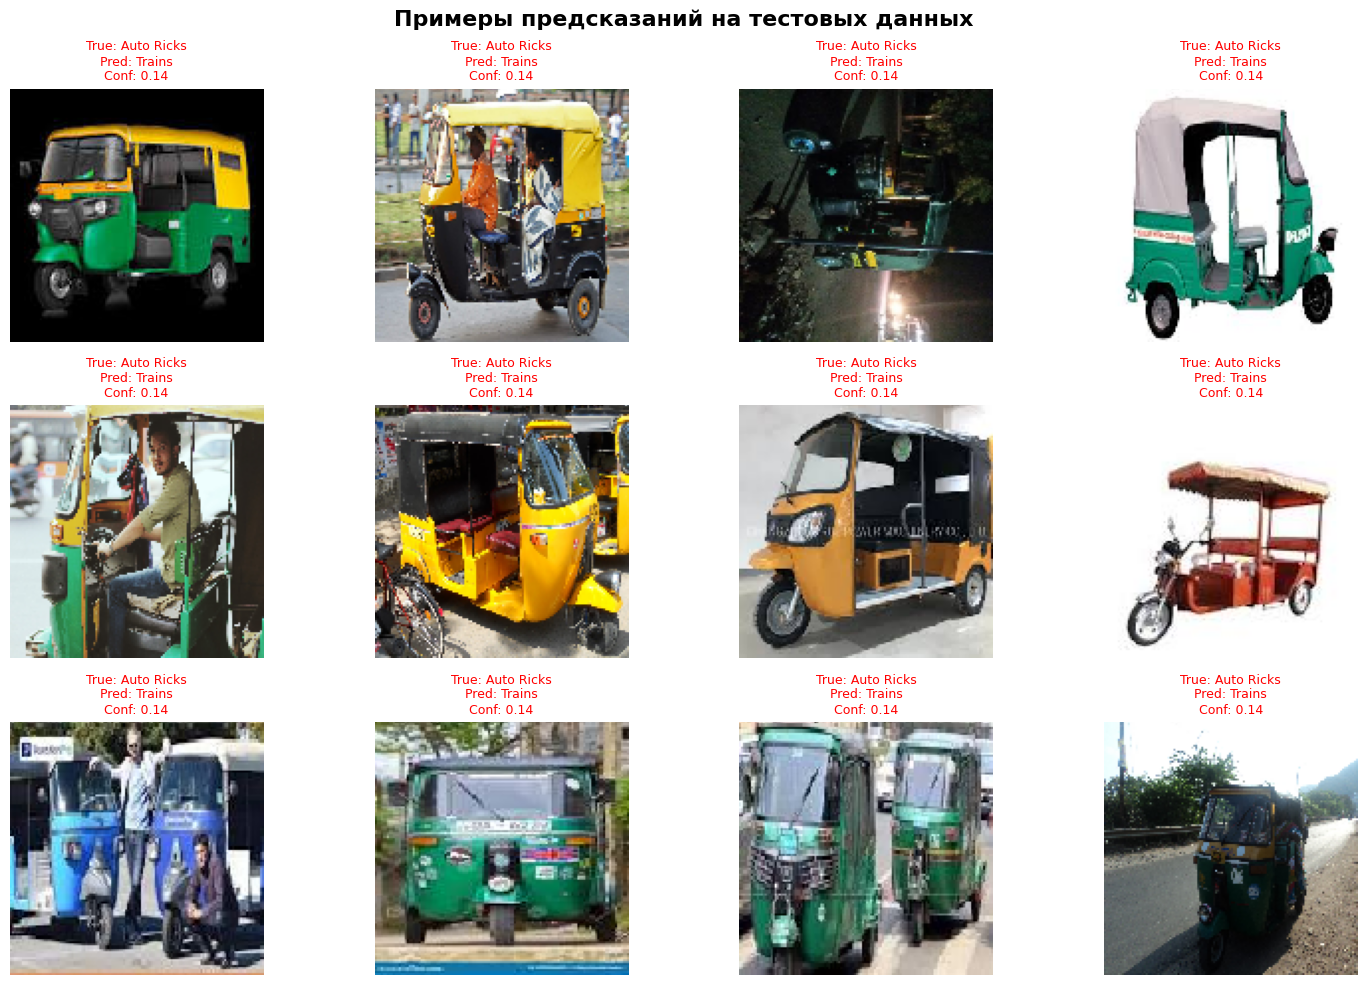

In [78]:
# 8. ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ
print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ")
print("="*60)

# Получаем батч тестовых данных
test_images, test_labels = next(test_generator)

# Делаем предсказания
predictions = model.predict(test_images[:12])

# Визуализируем результаты
class_names = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles",
               "Planes", "Ships", "Trains"]

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[i])

    true_class = np.argmax(test_labels[i])
    pred_class = np.argmax(predictions[i])
    confidence = np.max(predictions[i])

    true_name = class_names[true_class]
    pred_name = class_names[pred_class]

    color = 'green' if true_class == pred_class else 'red'

    plt.title(f"True: {true_name[:10]}\nPred: {pred_name[:10]}\nConf: {confidence:.2f}",
              color=color, fontsize=9)
    plt.axis('off')

plt.suptitle('Примеры предсказаний на тестовых данных', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

вывод

In [79]:
# 9. АНАЛИЗ РЕЗУЛЬТАТОВ
print("\n" + "="*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
print(f"   • Лучшая валидационная точность: {best_val_acc:.4f} ({best_val_acc*100:.1f}%)")
print(f"   • Лучшие валидационные потери: {best_val_loss:.4f}")
print(f"   • Финальная обучающая точность: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"   • Финальная валидационная точность: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"   • Финальная тестовая точность: {test_results[1]:.4f} ({test_results[1]*100:.1f}%)")

# Анализ переобучения
overfitting_gap = final_train_acc - final_val_acc
print(f"\nАНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
print(f"   • Разница (train - val): {overfitting_gap:.4f}")


АНАЛИЗ РЕЗУЛЬТАТОВ
ЛУЧШИЕ РЕЗУЛЬТАТЫ:
   • Лучшая валидационная точность: 0.1460 (14.6%)
   • Лучшие валидационные потери: 1.9458
   • Финальная обучающая точность: 0.1172 (11.7%)
   • Финальная валидационная точность: 0.1429 (14.3%)
   • Финальная тестовая точность: 0.1404 (14.0%)

АНАЛИЗ ПЕРЕОБУЧЕНИЯ:
   • Разница (train - val): -0.0257


Вывод

### 6. Ещё сеть

In [95]:
from keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.utils import to_categorical

# Автоматически получаем имена классов из папок
class_names = list(train_generator.class_indices.keys())

print(f"\nНайдено классов: {len(class_names)}")
print("Классы:")
for i, class_name in enumerate(class_names):
    print(f"  {i}. {class_name}")

# 3. ЗАГРУЗКА ResNet50V2
print("\nЗагружаем ResNet50V2...")

conv_base = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3),
    pooling=None
)

conv_base.trainable = False

# 4. ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ
print("\nИзвлекаем признаки...")

def extract_features(generator, conv_base):
    all_features = []
    all_labels = []

    for batch_idx in range(len(generator)):
        images, labels = generator[batch_idx]

        # Предобработка для ResNet
        preprocessed_images = preprocess_input(images)

        # Извлечение признаков
        features = conv_base.predict(preprocessed_images, verbose=0)

        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

# Извлекаем признаки
train_features, train_labels = extract_features(train_generator, conv_base)
val_features, val_labels = extract_features(val_generator, conv_base)
test_features, test_labels = extract_features(test_generator, conv_base)

print(f"Признаки извлечены:")
print(f"  Train: {train_features.shape}")
print(f"  Val: {val_features.shape}")
print(f"  Test: {test_features.shape}")

# 5. ПОДГОТОВКА ДАННЫХ (ИСПРАВЛЕННАЯ)
num_classes = len(class_names)
print(f"\nПодготовка данных для {num_classes} классов...")

# Ключевое исправление: проверяем формат меток
print(f"  Форма train_labels: {train_labels.shape}")

# Если метки уже one-hot (генератор с class_mode="categorical" возвращает one-hot)
if len(train_labels.shape) == 2 and train_labels.shape[1] == num_classes:
    print("  Метки уже one-hot, используем как есть")
    train_labels_onehot = train_labels
    val_labels_onehot = val_labels
    test_labels_onehot = test_labels
else:
    # Если метки - индексы
    print("  Метки - индексы, применяем to_categorical")
    train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
    val_labels_onehot = to_categorical(val_labels, num_classes=num_classes)
    test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

# Исправляем несоответствие размеров
if train_labels_onehot.shape[0] != train_features.shape[0]:
    print(f"\nИсправляем несоответствие: меток {train_labels_onehot.shape[0]}, признаков {train_features.shape[0]}")

    # Берем только первые N меток
    n_train = train_features.shape[0]
    n_val = val_features.shape[0]
    n_test = test_features.shape[0]

    train_labels_onehot = train_labels_onehot[:n_train]
    val_labels_onehot = val_labels_onehot[:n_val]
    test_labels_onehot = test_labels_onehot[:n_test]

print(f"\nФинальные размеры:")
print(f"  train: признаки {train_features.shape}, метки {train_labels_onehot.shape}")
print(f"  val: признаки {val_features.shape}, метки {val_labels_onehot.shape}")
print(f"  test: признаки {test_features.shape}, метки {test_labels_onehot.shape}")

# 6. КЛАССИФИКАТОР
def create_classifier(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Глобальный пулинг
    x = layers.GlobalAveragePooling2D()(inputs)

    # Полносвязные слои с Dropout
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Выходной слой
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)

classifier_model = create_classifier(train_features.shape[1:], num_classes)

classifier_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n Модель готова к обучению")


Найдено классов: 7
Классы:
  0. Auto Rickshaws
  1. Bikes
  2. Cars
  3. Motorcycles
  4. Planes
  5. Ships
  6. Trains

Загружаем ResNet50V2...

Извлекаем признаки...
Признаки извлечены:
  Train: (5587, 4, 4, 2048)
  Val: (4977, 4, 4, 2048)
  Test: (4998, 4, 4, 2048)

Подготовка данных для 7 классов...
  Форма train_labels: (5587, 7)
  Метки уже one-hot, используем как есть

Финальные размеры:
  train: признаки (5587, 4, 4, 2048), метки (5587, 7)
  val: признаки (4977, 4, 4, 2048), метки (4977, 7)
  test: признаки (4998, 4, 4, 2048), метки (4998, 7)

 Модель готова к обучению


In [96]:

# 7. ОБУЧЕНИЕ
print("\n" + "="*60)
print("ОБУЧЕНИЕ КЛАССИФИКАТОРА")
print("="*60)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history = classifier_model.fit(
    train_features,
    train_labels_onehot,
    epochs=50,
    batch_size=32,
    validation_data=(val_features, val_labels_onehot),
    callbacks=callbacks,
    verbose=1
)


ОБУЧЕНИЕ КЛАССИФИКАТОРА
Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1485 - loss: 2.0223 - val_accuracy: 0.2333 - val_loss: 1.9319 - learning_rate: 1.0000e-04
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1587 - loss: 1.9510 - val_accuracy: 0.3345 - val_loss: 1.8938 - learning_rate: 1.0000e-04
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2034 - loss: 1.9121 - val_accuracy: 0.3623 - val_loss: 1.8345 - learning_rate: 1.0000e-04
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2425 - loss: 1.8710 - val_accuracy: 0.3769 - val_loss: 1.7560 - learning_rate: 1.0000e-04
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2756 - loss: 1.8220 - val_accuracy: 0.3938 - val_loss: 1.6730 - learning_rate: 1.0000e-04
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3003 - loss: 1.7586 - val_accuracy: 0.3994 - val_loss: 1.6074 - learning_rate: 1.0000e-04
Epoch 7/50
175/175 ━━━━━━━━━━━━━━

если хочешь написать что-то

In [97]:
# 8. ОЦЕНКА
test_loss, test_accuracy = classifier_model.evaluate(
    test_features,
    test_labels_onehot,
    verbose=1
)

print(f"\nРезультаты:")
print(f"  Точность (accuracy): {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Потери: {test_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6608 - loss: 0.9967

Результаты:
  Точность (accuracy): 0.5754 (57.54%)
  Потери: 1.1368


вывод

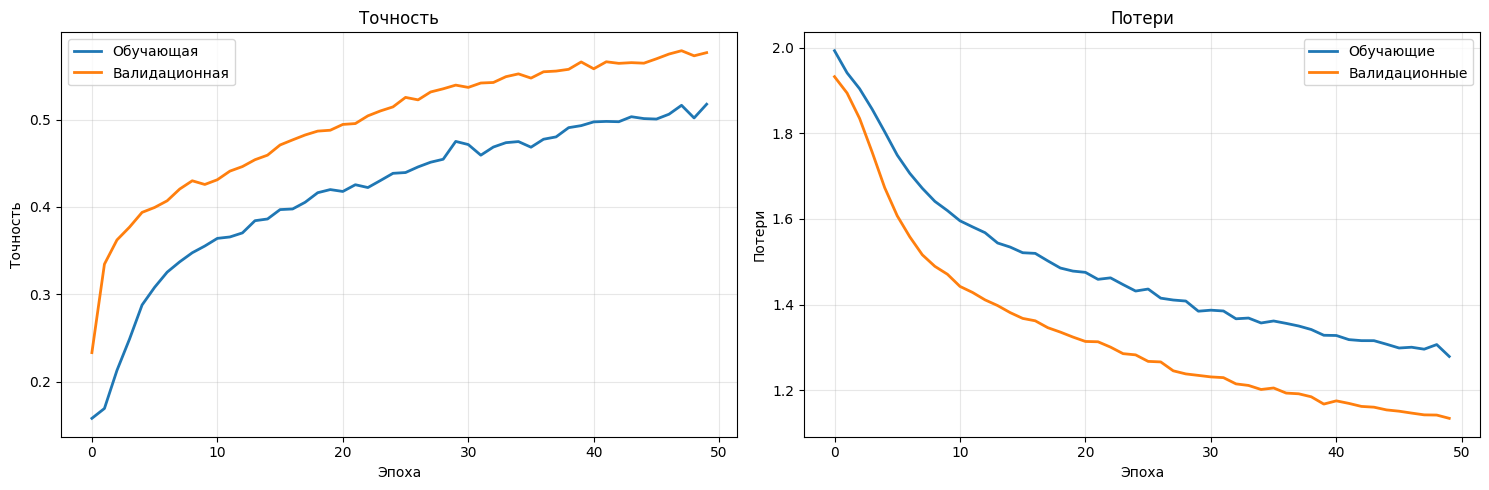

In [98]:
# 9. ВИЗУАЛИЗАЦИЯ
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Обучающая', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Валидационная', linewidth=2)
axes[0].set_title('Точность')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Точность')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Обучающие', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Валидационные', linewidth=2)
axes[1].set_title('Потери')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Потери')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

вывод

In [102]:
# 10. АНАЛИЗ РЕЗУЛЬТАТОВ
print("\n" + "="*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

# Используем переменные из вашего кода
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
print(f"   • Лучшая валидационная точность: {best_val_acc:.4f} ({best_val_acc*100:.1f}%)")
print(f"   • Лучшие валидационные потери: {best_val_loss:.4f}")
print(f"   • Финальная обучающая точность: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"   • Финальная валидационная точность: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"   • Финальная тестовая точность: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")

# Анализ переобучения
overfitting_gap = final_train_acc - final_val_acc
print(f"\nАНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
print(f"   • Разница (train - val): {overfitting_gap:.4f}")

# Сравнение точностей
print(f"\nСРАВНЕНИЕ ТОЧНОСТЕЙ:")
print(f"   • Разница train-test: {final_train_acc - test_accuracy:.4f}")
print(f"   • Разница val-test: {final_val_acc - test_accuracy:.4f}")



АНАЛИЗ РЕЗУЛЬТАТОВ
ЛУЧШИЕ РЕЗУЛЬТАТЫ:
   • Лучшая валидационная точность: 0.5789 (57.9%)
   • Лучшие валидационные потери: 1.1349
   • Финальная обучающая точность: 0.5176 (51.8%)
   • Финальная валидационная точность: 0.5767 (57.7%)
   • Финальная тестовая точность: 0.5754 (57.5%)

АНАЛИЗ ПЕРЕОБУЧЕНИЯ:
   • Разница (train - val): -0.0590

СРАВНЕНИЕ ТОЧНОСТЕЙ:
   • Разница train-test: -0.0578
   • Разница val-test: 0.0012


вывод

### 7. Сравниваем

Задание: "Сравнить полученные точности и потери для построенных глубоких сетей на этапе тестирования. Использовать метрики, необходимые в зависимости от
сбалансированности классов набора."
Метрики использовались accuracy только, вроде, поэтому на ней сравнивай

### 8. Выводы по ЛР

Какой-то вывод